In [1]:
"""
=====================================================================================
ANALIZADOR LIGERO DE ÁREA AFECTADA - Solo para Imágenes Ya Segmentadas
=====================================================================================

Versión simplificada sin SAM que asume:
- La imagen ya está segmentada (fondo negro/blanco)
- Solo necesitas detectar lesiones y calcular área
- Más rápido y liviano (no requiere SAM ni GPU)

Uso:
    analyzer = LightweightAreaAnalyzer()
    result = analyzer.analyze_segmented_image('imagen_segmentada.jpg', 'Gray Leaf Spot')
    analyzer.visualize_results(result)

Autor: Versión liviana 2025
"""

import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from typing import Dict, Tuple, Optional, Any
import warnings
warnings.filterwarnings('ignore')

# =====================================================================================
# PARÁMETROS DE DETECCIÓN DE LESIONES
# =====================================================================================

DETECTION_PARAMS = {
    "Gray Leaf Spot": {
        "method": "bright_spots",
        "brightness_threshold": 0.3,
        "min_area": 20,
        "max_area": 10000,
        "max_aspect_ratio": 6,
        "morphology_kernel": (7, 5),
        "color_overlay": [255, 100, 0],  # Naranja
        "description": "Manchas rectangulares grises"
    },
    
    "Northern Leaf Blight": {
        "method": "dark_spots",
        "hsv_lower": [8, 40, 50],
        "hsv_upper": [25, 200, 180],
        "min_area": 30,
        "max_area": 50000,
        "max_aspect_ratio": 20,
        "morphology_kernel": (11, 7),
        "color_overlay": [255, 0, 0],  # Rojo
        "description": "Lesiones alargadas necróticas"
    },
    
    "Common Rust": {
        "method": "rust_color",
        "hsv_lower": [5, 40, 40],
        "hsv_upper": [25, 255, 255],
        "min_area": 10,
        "max_area": 2000,
        "max_aspect_ratio": 3,
        "morphology_kernel": (3, 3),
        "color_overlay": [255, 255, 0],  # Amarillo
        "description": "Pústulas color óxido"
    },
    
    "Healthy": {
        "method": "none",
        "color_overlay": [0, 255, 0],  # Verde
        "description": "Hoja sana sin síntomas"
    }
}

# =====================================================================================
# DETECTOR DE LESIONES
# =====================================================================================

class LesionDetector:
    """Detector de lesiones específico para cada enfermedad"""
    
    @staticmethod
    def detect_gray_leaf_spot(image: np.ndarray, params: Dict) -> np.ndarray:
        """Detecta Gray Leaf Spot (manchas claras)"""
        lab = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
        l_channel = lab[:,:,0]
        
        # Máscara de hoja (píxeles que no son fondo negro)
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        leaf_mask = (gray > 15).astype(np.uint8) * 255
        
        leaf_pixels = l_channel[leaf_mask > 0]
        if len(leaf_pixels) == 0:
            return np.zeros_like(gray)
        
        leaf_mean = np.mean(leaf_pixels)
        leaf_std = np.std(leaf_pixels)
        threshold = leaf_mean + params["brightness_threshold"] * leaf_std
        
        bright_mask = (l_channel > threshold).astype(np.uint8) * 255
        lesion_mask = cv2.bitwise_and(bright_mask, leaf_mask)
        
        # Morfología
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, params["morphology_kernel"])
        lesion_mask = cv2.morphologyEx(lesion_mask, cv2.MORPH_CLOSE, kernel)
        lesion_mask = cv2.morphologyEx(lesion_mask, cv2.MORPH_OPEN, np.ones((2,2), np.uint8))
        
        # Filtrar por área y forma
        contours, _ = cv2.findContours(lesion_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        clean_mask = np.zeros_like(lesion_mask)
        
        for contour in contours:
            area = cv2.contourArea(contour)
            if params["min_area"] <= area <= params["max_area"]:
                x, y, w, h = cv2.boundingRect(contour)
                aspect_ratio = max(w, h) / max(min(w, h), 1)
                if aspect_ratio <= params["max_aspect_ratio"]:
                    cv2.fillPoly(clean_mask, [contour], 255)
        
        return clean_mask
    
    @staticmethod
    def detect_northern_leaf_blight(image: np.ndarray, params: Dict) -> np.ndarray:
        """Detecta Northern Leaf Blight (lesiones oscuras/marrones)"""
        hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        leaf_mask = (gray > 15).astype(np.uint8) * 255
        
        lower = np.array(params["hsv_lower"])
        upper = np.array(params["hsv_upper"])
        lesion_mask = cv2.inRange(hsv, lower, upper)
        lesion_mask = cv2.bitwise_and(lesion_mask, leaf_mask)
        
        # Morfología agresiva para unir fragmentos
        kernel_close = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, params["morphology_kernel"])
        lesion_mask = cv2.morphologyEx(lesion_mask, cv2.MORPH_CLOSE, kernel_close)
        
        kernel_dilate = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 3))
        lesion_mask = cv2.dilate(lesion_mask, kernel_dilate, iterations=1)
        
        kernel_open = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
        lesion_mask = cv2.morphologyEx(lesion_mask, cv2.MORPH_OPEN, kernel_open)
        
        # Filtrar por área mínima
        contours, _ = cv2.findContours(lesion_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        clean_mask = np.zeros_like(lesion_mask)
        
        for contour in contours:
            if cv2.contourArea(contour) >= params["min_area"]:
                cv2.fillPoly(clean_mask, [contour], 255)
        
        return clean_mask
    
    @staticmethod
    def detect_common_rust(image: np.ndarray, params: Dict) -> np.ndarray:
        """Detecta Common Rust (pústulas color óxido)"""
        hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        leaf_mask = (gray > 15).astype(np.uint8) * 255
        
        lower = np.array(params["hsv_lower"])
        upper = np.array(params["hsv_upper"])
        color_mask = cv2.inRange(hsv, lower, upper)
        lesion_mask = cv2.bitwise_and(color_mask, leaf_mask)
        
        # Limpieza
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, params["morphology_kernel"])
        lesion_mask = cv2.morphologyEx(lesion_mask, cv2.MORPH_CLOSE, kernel)
        lesion_mask = cv2.morphologyEx(lesion_mask, cv2.MORPH_OPEN, np.ones((2,2), np.uint8))
        
        # Filtrar por área y forma
        contours, _ = cv2.findContours(lesion_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        clean_mask = np.zeros_like(lesion_mask)
        
        for contour in contours:
            area = cv2.contourArea(contour)
            if params["min_area"] <= area <= params["max_area"]:
                x, y, w, h = cv2.boundingRect(contour)
                aspect_ratio = max(w, h) / max(min(w, h), 1)
                if aspect_ratio <= params["max_aspect_ratio"]:
                    cv2.fillPoly(clean_mask, [contour], 255)
        
        return clean_mask
    
    @staticmethod
    def detect_lesions(image: np.ndarray, disease_name: str) -> np.ndarray:
        """Función principal de detección según enfermedad"""
        if disease_name == "Healthy":
            return np.zeros(image.shape[:2], dtype=np.uint8)
        
        params = DETECTION_PARAMS.get(disease_name)
        if not params:
            return np.zeros(image.shape[:2], dtype=np.uint8)
        
        method = params.get("method")
        
        if method == "bright_spots":
            return LesionDetector.detect_gray_leaf_spot(image, params)
        elif method == "dark_spots":
            return LesionDetector.detect_northern_leaf_blight(image, params)
        elif method == "rust_color":
            return LesionDetector.detect_common_rust(image, params)
        else:
            return np.zeros(image.shape[:2], dtype=np.uint8)

# =====================================================================================
# ANALIZADOR LIGERO PRINCIPAL
# =====================================================================================

class LightweightAreaAnalyzer:
    """
    Analizador ligero para imágenes YA SEGMENTADAS
    No requiere SAM ni GPU - Solo OpenCV
    """
    
    def __init__(self):
        """Inicializa el analizador ligero"""
        print("=" * 70)
        print("🌽 ANALIZADOR LIGERO DE ÁREA AFECTADA")
        print("Para imágenes ya segmentadas (sin SAM)")
        print("=" * 70)
        
        self.detector = LesionDetector()
        print("✅ Sistema inicializado\n")
    
    def analyze_segmented_image(self, image_path: str, disease_name: str) -> Dict[str, Any]:
        """
        Analiza una imagen YA SEGMENTADA
        
        Args:
            image_path: Ruta a la imagen segmentada
            disease_name: Nombre de la enfermedad
        
        Returns:
            Dict con resultados del análisis
        """
        print(f"\n🔬 ANALIZANDO: {Path(image_path).name}")
        print(f"🦠 Enfermedad: {disease_name}")
        print("=" * 70)
        
        try:
            # Cargar imagen
            image = cv2.imread(str(image_path))
            if image is None:
                return {
                    'success': False,
                    'error': f'No se pudo cargar la imagen: {image_path}',
                    'filename': Path(image_path).name
                }
            
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            
            # PASO 1: Detectar lesiones
            print("\n📍 Detectando lesiones...")
            print(f"  🔍 Método: {DETECTION_PARAMS[disease_name]['method']}")
            
            lesion_mask = self.detector.detect_lesions(image, disease_name)
            
            # PASO 2: Calcular métricas
            print("\n📍 Calculando métricas...")
            
            gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
            leaf_area = np.sum(gray > 15)  # Píxeles que no son fondo negro
            lesion_area = np.sum(lesion_mask > 0)
            
            percentage_affected = (lesion_area / leaf_area * 100) if leaf_area > 0 else 0
            
            # Clasificar severidad
            if percentage_affected == 0:
                severity = "Ninguna"
            elif percentage_affected <= 10:
                severity = "Leve"
            elif percentage_affected <= 30:
                severity = "Moderada"
            elif percentage_affected <= 50:
                severity = "Severa"
            else:
                severity = "Muy Severa"
            
            # Contar lesiones
            contours, _ = cv2.findContours(lesion_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            num_lesions = len([c for c in contours if cv2.contourArea(c) > 10])
            avg_lesion_area = lesion_area / max(num_lesions, 1)
            
            print(f"  ✅ Área de hoja: {leaf_area:,} px")
            print(f"  ✅ Área afectada: {lesion_area:,} px ({percentage_affected:.1f}%)")
            print(f"  ✅ Lesiones detectadas: {num_lesions}")
            print(f"  ✅ Severidad: {severity}")
            
            # Compilar resultados
            result = {
                'success': True,
                'filename': Path(image_path).name,
                'disease_name': disease_name,
                'disease_description': DETECTION_PARAMS[disease_name]['description'],
                
                # Imágenes
                'original_image': image,
                'lesion_mask': lesion_mask,
                
                # Métricas
                'leaf_area_px': int(leaf_area),
                'lesion_area_px': int(lesion_area),
                'percentage_affected': round(percentage_affected, 2),
                'severity': severity,
                'num_lesions': num_lesions,
                'avg_lesion_area_px': round(avg_lesion_area, 2),
                
                # Overlay color
                'overlay_color': DETECTION_PARAMS[disease_name]['color_overlay']
            }
            
            print("\n" + "=" * 70)
            print("✅ ANÁLISIS COMPLETADO")
            print("=" * 70)
            
            return result
            
        except Exception as e:
            return {
                'success': False,
                'error': str(e),
                'filename': Path(image_path).name
            }
    
    def visualize_results(self, result: Dict[str, Any], save_path: Optional[str] = None):
        """
        Genera visualización de los resultados
        
        Args:
            result: Resultado del análisis
            save_path: Ruta opcional para guardar
        """
        if not result['success']:
            print(f"❌ No se puede visualizar: {result['error']}")
            return
        
        original_img = result['original_image']
        lesion_mask = result['lesion_mask']
        overlay_color = result['overlay_color']
        
        # Crear overlay
        overlay = np.zeros_like(original_img)
        overlay[lesion_mask > 0] = overlay_color
        
        # Combinar imagen + overlay
        result_img = cv2.addWeighted(original_img, 0.7, overlay, 0.3, 0)
        
        # Dibujar contornos
        contours, _ = cv2.findContours(lesion_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cv2.drawContours(result_img, contours, -1, overlay_color, 2)
        
        # Crear figura
        fig, axes = plt.subplots(1, 3, figsize=(18, 6))
        
        # Imagen original
        axes[0].imshow(original_img)
        axes[0].set_title('Imagen Segmentada Original', 
                         fontsize=12, fontweight='bold')
        axes[0].axis('off')
        
        # Máscara de lesiones
        axes[1].imshow(lesion_mask, cmap='Reds')
        axes[1].set_title(f'Lesiones Detectadas\n{result["num_lesions"]} lesiones', 
                         fontsize=12, fontweight='bold')
        axes[1].axis('off')
        
        # Resultado final
        axes[2].imshow(result_img)
        axes[2].set_title(f'Análisis Final\n{result["percentage_affected"]}% afectado', 
                         fontsize=12, fontweight='bold')
        axes[2].axis('off')
        
        # Título general
        fig.suptitle(
            f'{result["filename"]} - {result["disease_name"]}\n'
            f'Severidad: {result["severity"]} | {result["disease_description"]}',
            fontsize=14, fontweight='bold'
        )
        
        plt.tight_layout()
        
        # Guardar si se especifica
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            print(f"\n📁 Visualización guardada: {save_path}")
        
        plt.show()
        
        # Imprimir reporte
        self._print_detailed_report(result)
    
    def _print_detailed_report(self, result: Dict[str, Any]):
        """Imprime reporte detallado"""
        print("\n" + "=" * 70)
        print("📊 REPORTE DETALLADO")
        print("=" * 70)
        print(f"📄 Archivo: {result['filename']}")
        print(f"🦠 Enfermedad: {result['disease_name']}")
        print(f"📝 Descripción: {result['disease_description']}")
        print("-" * 70)
        print(f"📏 Área total de hoja: {result['leaf_area_px']:,} píxeles")
        print(f"🔴 Área afectada: {result['lesion_area_px']:,} píxeles")
        print(f"📊 Porcentaje afectado: {result['percentage_affected']}%")
        print(f"⚖️ Nivel de severidad: {result['severity']}")
        print(f"🎯 Número de lesiones: {result['num_lesions']}")
        print(f"📐 Área promedio/lesión: {result['avg_lesion_area_px']:.1f} píxeles")
        print("=" * 70)
    
    def batch_analyze(self, image_folder: str, disease_name: str,
                     save_results: bool = True, output_folder: str = "batch_results_light"):
        """
        Analiza múltiples imágenes en batch
        
        Args:
            image_folder: Carpeta con imágenes segmentadas
            disease_name: Enfermedad a analizar
            save_results: Si guardar visualizaciones
            output_folder: Carpeta de salida
        """
        image_folder = Path(image_folder)
        if not image_folder.exists():
            print(f"❌ Carpeta no existe: {image_folder}")
            return []
        
        if save_results:
            output_path = Path(output_folder)
            output_path.mkdir(exist_ok=True)
        
        # Buscar imágenes
        extensions = ['*.jpg', '*.jpeg', '*.png', '*.JPG', '*.JPEG', '*.PNG']
        image_files = []
        for ext in extensions:
            image_files.extend(image_folder.glob(ext))
        
        if not image_files:
            print(f"❌ No se encontraron imágenes en {image_folder}")
            return []
        
        print(f"\n🔄 ANÁLISIS EN BATCH")
        print(f"📂 Carpeta: {image_folder}")
        print(f"🦠 Enfermedad: {disease_name}")
        print(f"📊 Total imágenes: {len(image_files)}\n")
        
        results = []
        
        for idx, img_path in enumerate(image_files, 1):
            print(f"\n{'='*70}")
            print(f"[{idx}/{len(image_files)}] Procesando: {img_path.name}")
            print(f"{'='*70}")
            
            result = self.analyze_segmented_image(str(img_path), disease_name)
            
            if result['success']:
                results.append(result)
                
                if save_results:
                    save_path = output_path / f"result_{img_path.stem}.png"
                    self.visualize_results(result, save_path=str(save_path))
            else:
                print(f"⚠️ Falló: {result['error']}")
        
        # Resumen
        print("\n" + "=" * 70)
        print("📊 RESUMEN DEL BATCH")
        print("=" * 70)
        print(f"✅ Analizadas exitosamente: {len(results)}/{len(image_files)}")
        
        if results:
            avg_percentage = np.mean([r['percentage_affected'] for r in results])
            avg_lesions = np.mean([r['num_lesions'] for r in results])
            
            print(f"📊 Porcentaje afectado promedio: {avg_percentage:.2f}%")
            print(f"🎯 Lesiones promedio: {avg_lesions:.1f}")
        
        print("=" * 70)
        
        return results

# =====================================================================================
# FUNCIÓN DE EJEMPLO
# =====================================================================================

def demo_usage():
    """Ejemplo de uso"""
    print("""
    ╔════════════════════════════════════════════════════════════════════╗
    ║  ANALIZADOR LIGERO - Para imágenes ya segmentadas                ║
    ╚════════════════════════════════════════════════════════════════════╝
    
    # 1. Inicializar (NO requiere SAM)
    analyzer = LightweightAreaAnalyzer()
    
    # 2. Analizar imagen ya segmentada
    result = analyzer.analyze_segmented_image(
        image_path='imagen_segmentada.jpg',
        disease_name='Gray Leaf Spot'
    )
    
    # 3. Visualizar
    analyzer.visualize_results(result, save_path='resultado.png')
    
    # 4. Batch processing
    results = analyzer.batch_analyze(
        image_folder='carpeta_imagenes_segmentadas/',
        disease_name='Northern Leaf Blight'
    )
    
    ╔════════════════════════════════════════════════════════════════════╗
    ║  ENFERMEDADES DISPONIBLES:                                        ║
    ╚════════════════════════════════════════════════════════════════════╝
    
    • 'Gray Leaf Spot'
    • 'Northern Leaf Blight'
    • 'Common Rust'
    • 'Healthy'
    
    ⚡ VENTAJAS vs versión completa:
    • No requiere SAM (no descarga 300+ MB)
    • No requiere GPU
    • Más rápido (solo detección de lesiones)
    • Ideal para imágenes ya procesadas
    """)

if __name__ == "__main__":
    demo_usage()


    ╔════════════════════════════════════════════════════════════════════╗
    ║  ANALIZADOR LIGERO - Para imágenes ya segmentadas                ║
    ╚════════════════════════════════════════════════════════════════════╝
    
    # 1. Inicializar (NO requiere SAM)
    analyzer = LightweightAreaAnalyzer()
    
    # 2. Analizar imagen ya segmentada
    result = analyzer.analyze_segmented_image(
        image_path='imagen_segmentada.jpg',
        disease_name='Gray Leaf Spot'
    )
    
    # 3. Visualizar
    analyzer.visualize_results(result, save_path='resultado.png')
    
    # 4. Batch processing
    results = analyzer.batch_analyze(
        image_folder='carpeta_imagenes_segmentadas/',
        disease_name='Northern Leaf Blight'
    )
    
    ╔════════════════════════════════════════════════════════════════════╗
    ║  ENFERMEDADES DISPONIBLES:                                        ║
    ╚════════════════════════════════════════════════════════════════════╝
    
    • 'Gray Le

🌽 ANALIZADOR LIGERO DE ÁREA AFECTADA
Para imágenes ya segmentadas (sin SAM)
✅ Sistema inicializado


🔬 ANALIZANDO: segmented_northern4a.jpg
🦠 Enfermedad: Northern Leaf Blight

📍 Detectando lesiones...
  🔍 Método: dark_spots

📍 Calculando métricas...
  ✅ Área de hoja: 133,952 px
  ✅ Área afectada: 24,774 px (18.5%)
  ✅ Lesiones detectadas: 9
  ✅ Severidad: Moderada

✅ ANÁLISIS COMPLETADO

📁 Visualización guardada: resultado.png


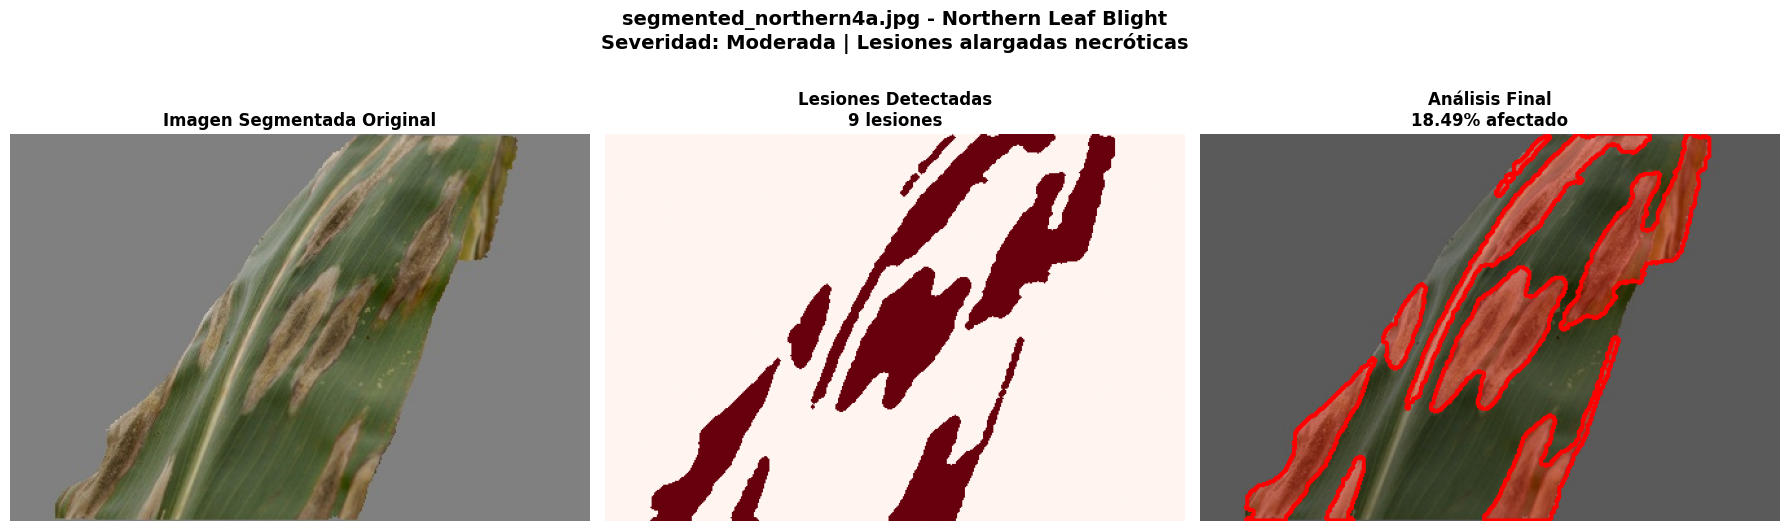


📊 REPORTE DETALLADO
📄 Archivo: segmented_northern4a.jpg
🦠 Enfermedad: Northern Leaf Blight
📝 Descripción: Lesiones alargadas necróticas
----------------------------------------------------------------------
📏 Área total de hoja: 133,952 píxeles
🔴 Área afectada: 24,774 píxeles
📊 Porcentaje afectado: 18.49%
⚖️ Nivel de severidad: Moderada
🎯 Número de lesiones: 9
📐 Área promedio/lesión: 2752.7 píxeles
% Afectado: 18.49%
Severidad: Moderada
Lesiones: 9


In [3]:
analyzer = LightweightAreaAnalyzer()

# Analizar tu imagen
result = analyzer.analyze_segmented_image(
    image_path=r"manual\segmented_northern4a.jpg",
    disease_name='Northern Leaf Blight'
)

# Visualizar
analyzer.visualize_results(result, save_path='resultado.png')

# Ver métricas
print(f"% Afectado: {result['percentage_affected']}%")
print(f"Severidad: {result['severity']}")
print(f"Lesiones: {result['num_lesions']}")

In [ ]:
analyzer = LightweightAreaAnalyzer()

# Analizar toda una carpeta
results = analyzer.batch_analyze(
    image_folder=r"I:\FINAL PROC IMG\entregav2\v16\manual",
    disease_name='Northern Leaf Blight',
    save_results=True,
    output_folder='resultados_batch'
)

# Ver estadísticas
import numpy as np
print(f"Promedio afectado: {np.mean([r['percentage_affected'] for r in results]):.1f}%")